# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Проект: прогнозирование оттока клиентов в сети отелей "Как в гостях"

Цель проекта: разработать систему, которая будет прогнозировать отмену бронирования клиентом

План работы: 
- провести предобработку данных
- сформулировать задачу машинного обучения, на основе бизнес-задачи
- создать наиболее подходящую для этой задачи модель машинного обучения
- получить прогноз прибыли с внедрением данной системы, на ее основе сделать вывод о рентабельности вложений в систему депозитов
- провести исследовательский анализ данных, на его основе выделить отличительные признаки "ненадежного" клинта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

### Шаг 1. Откройте файлы с данными

Откроем файлы данных, поместим их в два разных датафрейма

In [2]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')


### Шаг 2. Предобработка и исследовательский анализ данных

В обоих датафрейме пропусков нет, тренировочный в два раза больше тестового.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Удалим лишнее пропуски в ячейках столбцах meal и reserved_room_type в обоих наборах данных

In [5]:
df_train['meal'] = df_train['meal'].str[:2]
df_test['meal'] = df_test['meal'].str[:2]


In [6]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].str[:1]
df_test['reserved_room_type'] = df_test['reserved_room_type'].str[:1]

Проверим наличие пропусков в обоих датафреймах

In [7]:
print(df_test.isna().sum().sum())
df_train.isna().sum().sum()

0


0

В столбце id нет дубликатов, следовательно, все опреации бронирования различны

In [8]:
print(len(pd.unique(df_train['id'])))
print(len(pd.unique(df_test['id'])))

65229
32412


Удалим столбец id из обоих датафреймов, для последующей работы он не пригодится

In [9]:
df_train = df_train.drop('id', axis = 1)
df_test = df_test.drop('id', axis = 1)

В тренировочном датафрейме около 30% полных дубликатов, а в тестовом около 20%. Удалять такой объем данных неккоректно, а обработать их без связи с поставщиками данных не представляется возможным- оставим их в датафреймах. А еще такое количество дубликатов можно объяснить особенностями бизнеса: люди стараются останавливаться в "проверенных" отелях, а следовательно и параметры заказа зачастую не изменяются.

In [10]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

21377
7717


Бронирование 8 парковочных мест, скорее всего, выброс, поэтому удалим такие ячейки (их всего 2)

In [11]:
print(len(df_test[df_test['required_car_parking_spaces'] == 8]))
df_test = df_test[df_test['required_car_parking_spaces'] != 8]


2


In [12]:
print(df_test['children'].unique())
print(df_train['children'].unique())

[0. 2. 1. 3.]
[0. 1. 2. 3.]


По тем же причинам, удалим все бронирования с 9 и 10 младенцами (всего 2)

In [13]:
print(df_test['babies'].unique())
print(df_train['babies'].unique())
print(len(df_train[df_train['babies'] == 9]))
print(len(df_train[df_train['babies'] == 10]))
df_train = df_train[df_train['babies'] != 9]
df_train = df_train[df_train['babies'] != 10]

[0. 1. 2.]
[ 0.  1.  2. 10.  9.]
1
1


Удалим строки, в которых adults = 0, очевидно, такого не может быть.

In [14]:
print(len(df_train[(df_train['adults'] == 0)]))
print(len(df_test[(df_test['adults'] == 0)]))
df_train = df_train[(df_train['adults'] != 0)]
df_test = df_test[(df_test['adults'] != 0)]

166
69


Удалим столбец arrival_date_year, так как анализировать его с помощью машинного обучения некорректно : количество отказов от брони зависит не от года бронирования , а от каких-то экономических изменений , с которыми этот год связан, но такой анализ неподвластен модели. В любом случае, нам нужно создать модель для предсказания поведения клиента, а клиенты не будут вести, себя так , как вели бы себя в 2015 году.

In [15]:
df_train = df_train.drop('arrival_date_year',axis = 1)
df_test = df_test.drop('arrival_date_year',axis = 1)

Функци month, которая будет переводить письменное название месяца в числовое, а также создадим столбец season, в котором находится информация о сезоне каждой операции

In [16]:
def month(df_train):
    for i in df_train.index:
        if df_train['arrival_date_month'][i] == "January":
            df_train['arrival_date_month'][i] = 1;
            df_train['season'][i] = '1'
        elif df_train['arrival_date_month'][i] == "February":
            df_train['arrival_date_month'][i] = 2;
            df_train['season'][i] = '1'
        elif df_train['arrival_date_month'][i] == "March":
            df_train['arrival_date_month'][i] = 3;
            df_train['season'][i] = '2'
        elif df_train['arrival_date_month'][i] == "April":
            df_train['arrival_date_month'][i] = 4;
            df_train['season'][i] = '2'
        elif df_train['arrival_date_month'][i] == "May":
            df_train['arrival_date_month'][i] = 5;
            df_train['season'][i] = '2'
        elif df_train['arrival_date_month'][i] == "June":
            df_train['arrival_date_month'][i] = 6;
            df_train['season'][i] = '3'
        elif df_train['arrival_date_month'][i] == "July":
            df_train['arrival_date_month'][i] = 7;
            df_train['season'][i] = '3'
        elif df_train['arrival_date_month'][i] == "August":
            df_train['arrival_date_month'][i] = 8;
            df_train['season'][i] = "3";
        elif df_train['arrival_date_month'][i] == "September":
            df_train['arrival_date_month'][i] = 9;
            df_train['season'][i] = '2'
        elif df_train['arrival_date_month'][i] == "October":
            df_train['arrival_date_month'][i] = 10;
            df_train['season'][i] = '2'
        elif df_train['arrival_date_month'][i] == "November":
            df_train['arrival_date_month'][i] = 11;
            df_train['season'][i] = '2'
        elif df_train['arrival_date_month'][i] == "December":
            df_train['arrival_date_month'][i] = 12;
            df_train['season'][i] = "1";
    df_train['arrival_date_month'] = df_train['arrival_date_month'].astype('int')
    return df_train


Примени функцию month к обоим датафреймам

In [17]:
df_test['season'] = 's'
df_train['season'] = 's'

In [18]:
warnings.filterwarnings('ignore')
df_train = month(df_train)  
df_train['season'] = df_train['season'].astype('int')

In [19]:
warnings.filterwarnings('ignore')
df_test = month(df_test)


In [20]:
df_test['season'] = df_test['season'].astype('int')

Функция meal переводит параметры  данные столбца meal в цифровые

In [21]:
warnings.filterwarnings('ignore')
def meal(df):
    for i in df.index:
        if df['meal'][i] == "SC":
            df['meal'][i] = 0
        elif df['meal'][i] == "BB":
            df['meal'][i] = 1
        elif df['meal'][i] == "HB":
            df['meal'][i] = 2
        elif df['meal'][i] == "FB":
            df['meal'][i] = 3
    df['meal'] = df['meal'].astype('int')
    return df
df_train = meal(df_train)
df_test = meal(df_test)



Проведем исследовательский анализ данных

Объединим два датафрейма в один, для более достоверного составления портрета 'ненадежного' клиента.

In [22]:
df = pd.concat([df_train,df_test])

Построим матрицу корреляций полученного датафрейма. Сильнее всего с целевым признаком коррелирует признак lead_time


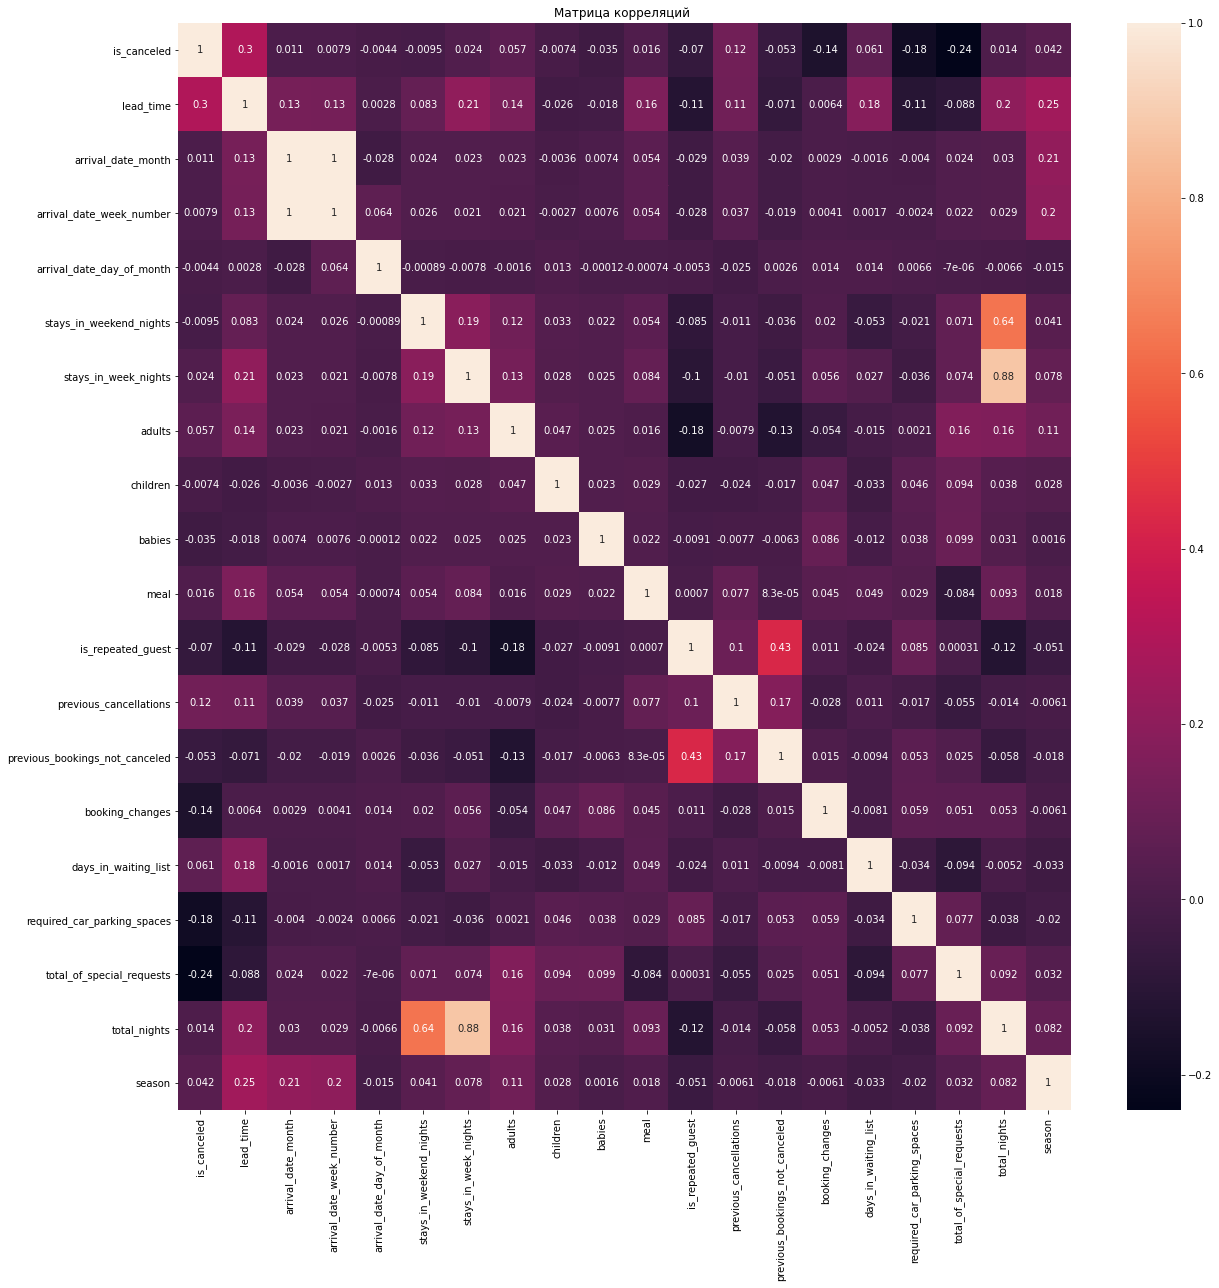

In [23]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(), annot = True)
plt.title("Матрица корреляций ")
plt.show()

Больше половины клиентов приезжают в межсезонье, меньше всего отель поссещают зимой

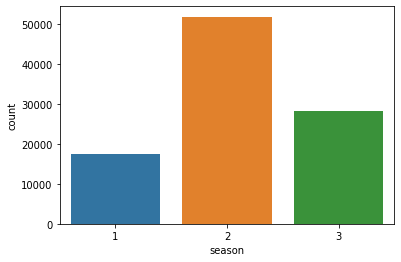

In [24]:
sns.countplot(data= df, x = 'season')
plt.show()

Около 40% всех клиентов из страны PRT, на втором месте FRA , из клиентов из этой страны около 10%

In [25]:
df.groupby(by = 'country')['country'].count().sort_values(ascending = False)[:10]

country
PRT    38671
FRA     9426
GBR     9019
ESP     6817
DEU     6253
ITA     3471
IRL     2501
BEL     2111
BRA     1959
NLD     1866
Name: country, dtype: int64

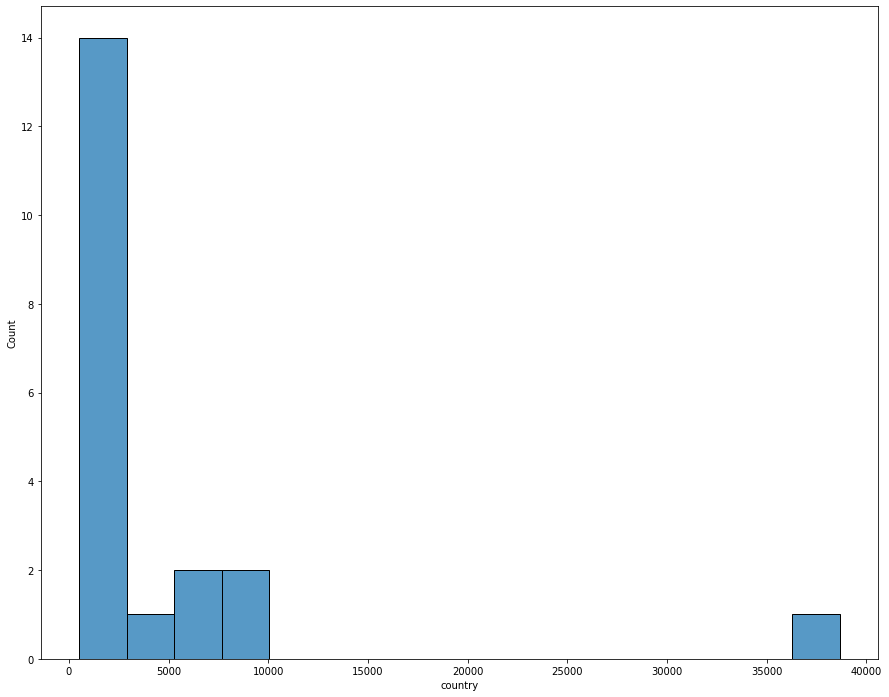

In [26]:
plt.figure(figsize = (15,12))
sns.histplot(data= df.groupby(by = 'country')['country'].count().sort_values(ascending = False)[:20])
plt.show()

Чаще всего, люди не бронируют более чем за 50 дней до даты заезда.

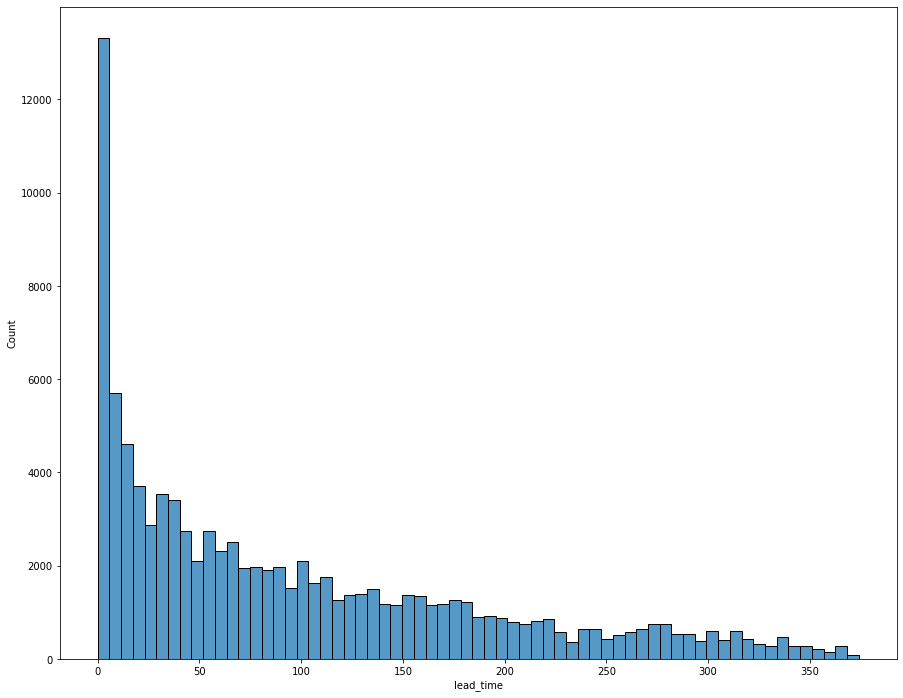

In [27]:
plt.figure(figsize = (15,12))
sns.histplot(data= df, x = 'lead_time')
plt.show()

Более 70% клиентов бронируют номера класса А, что хорошо для отеля, ведь прибыль с таких номеров максимальна. Реже всего бронируют номера класса C,G,B.

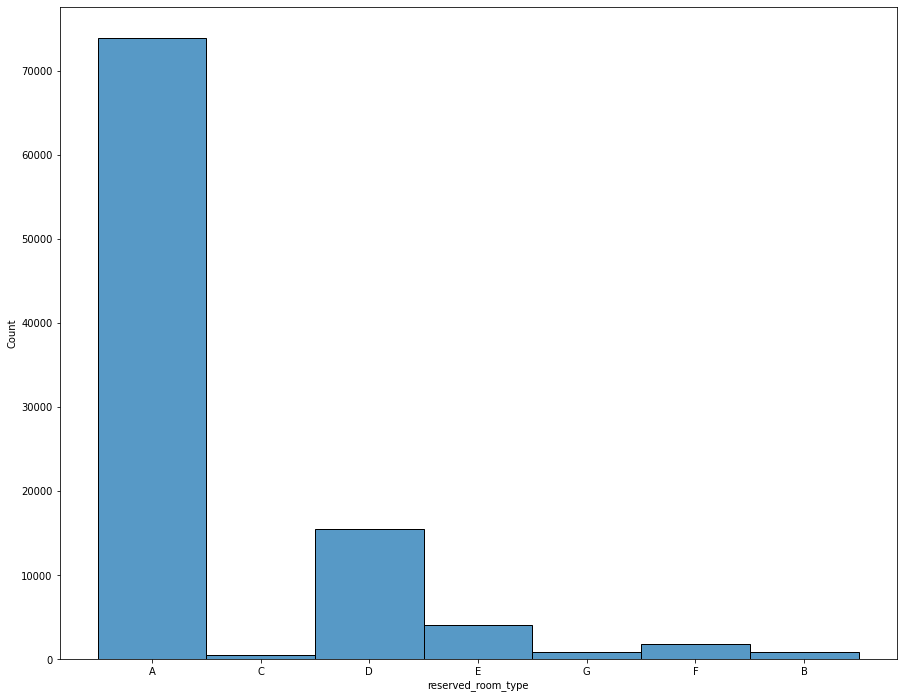

In [28]:
plt.figure(figsize = (15,12))
sns.histplot(data= df, x = 'reserved_room_type')
plt.show()

Более 70% клиентов опличивают завтрак, а вот оплачивают завтрак, обед и ужин единицы.

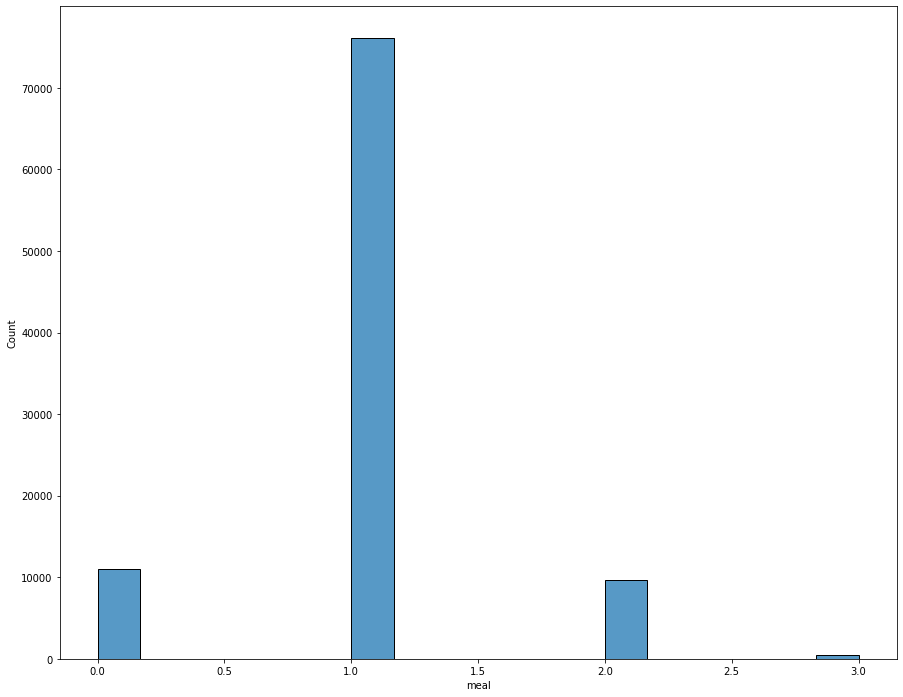

In [29]:
plt.figure(figsize = (15,12))
sns.histplot(data= df, x = 'meal')
plt.show()

Бронирование отменяют примерно в 40% случаев

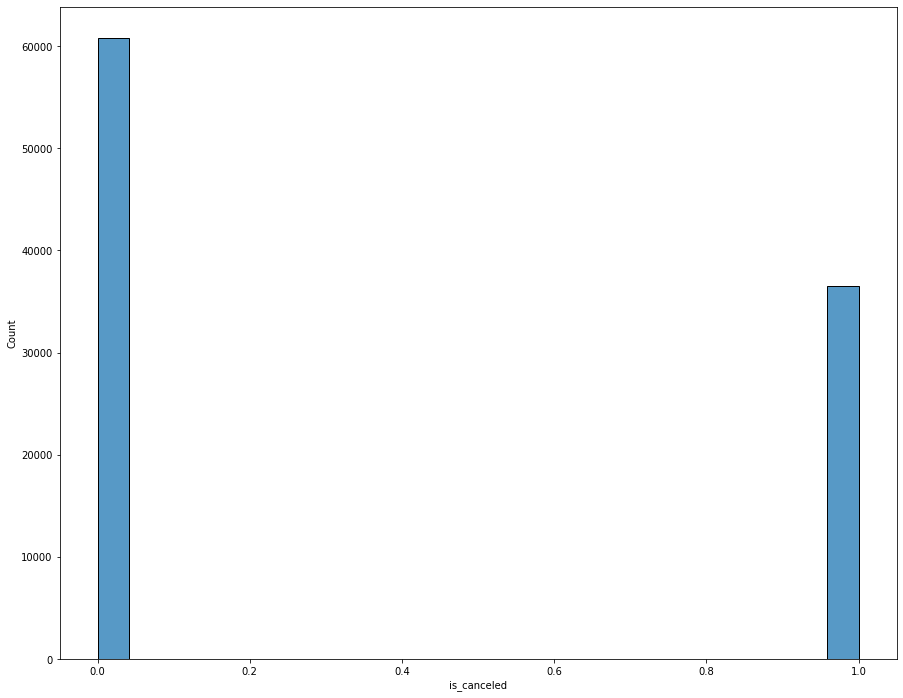

In [30]:
plt.figure(figsize = (15,12))
sns.histplot(data= df, x = 'is_canceled')
plt.show()

Люди без младенцев в два раза чаще отменяют бронь, чем люди с младенцами. Люди , которые оплатили обед, завтрак и ужин отменяют бронь в два раза чаще остальных, но делать какие-то выводы по этому факту нельзя, так как таких людей очень мало. 

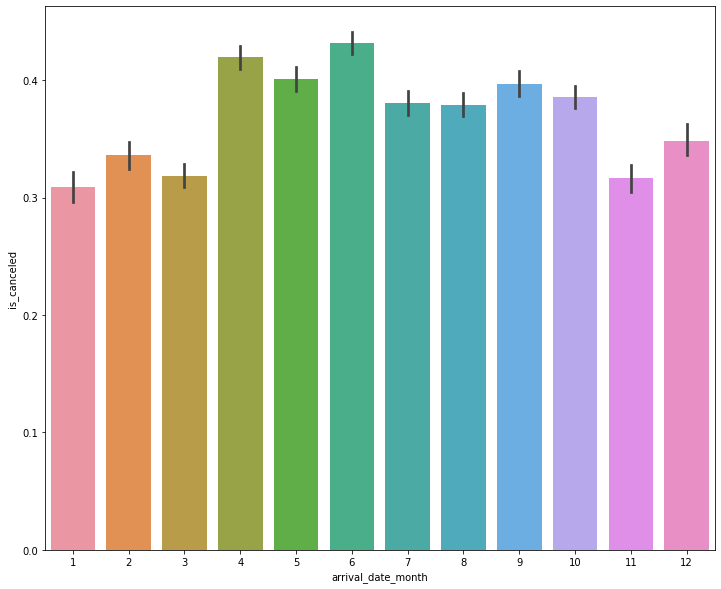

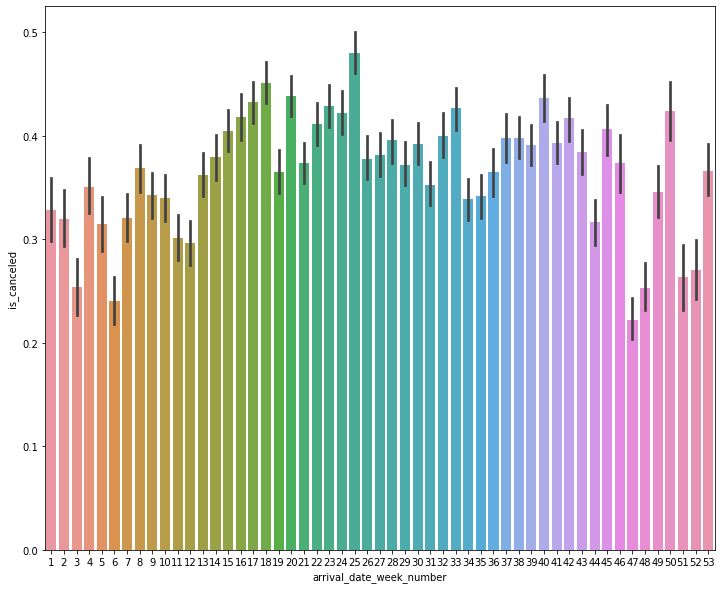

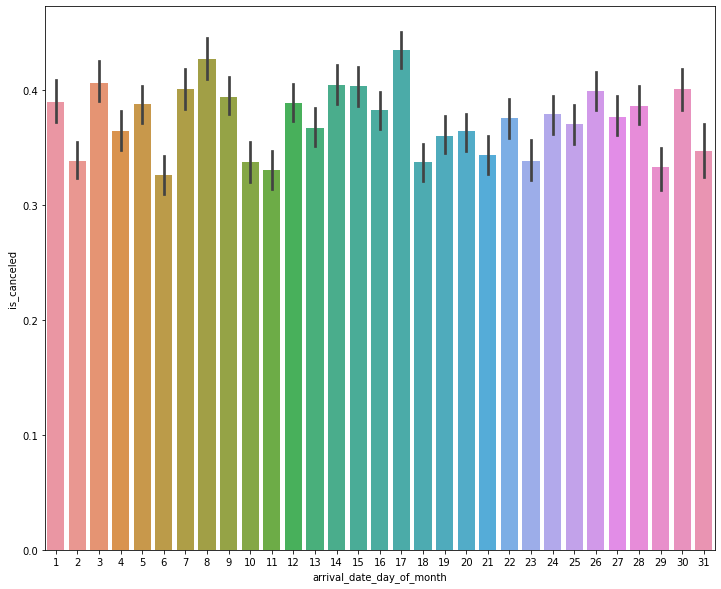

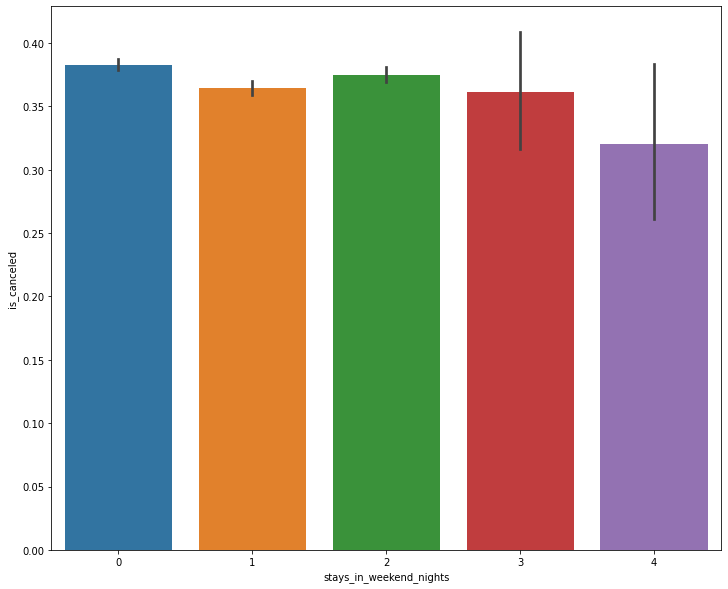

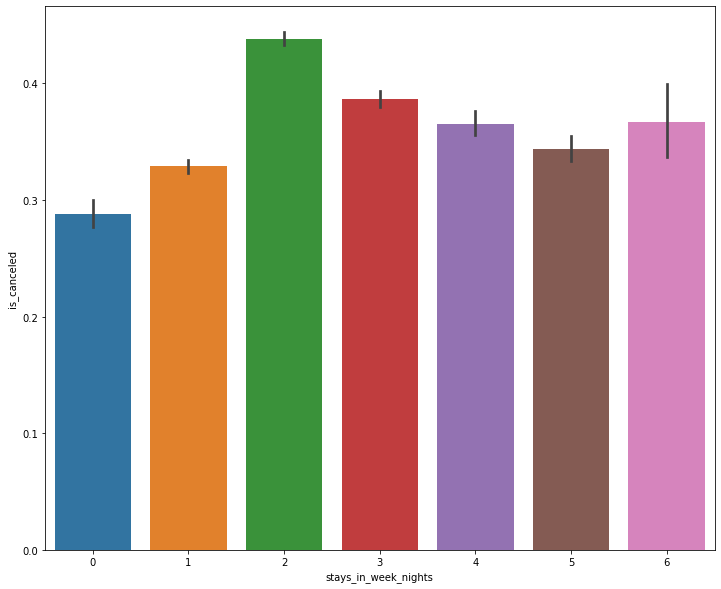

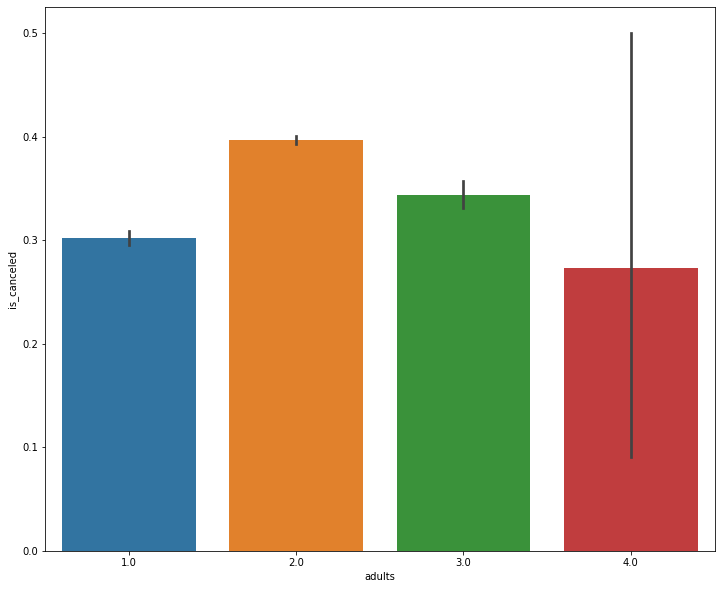

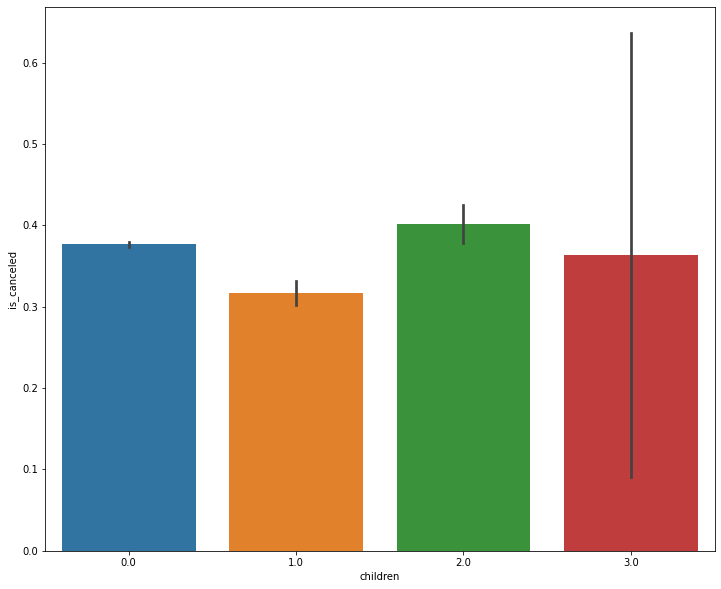

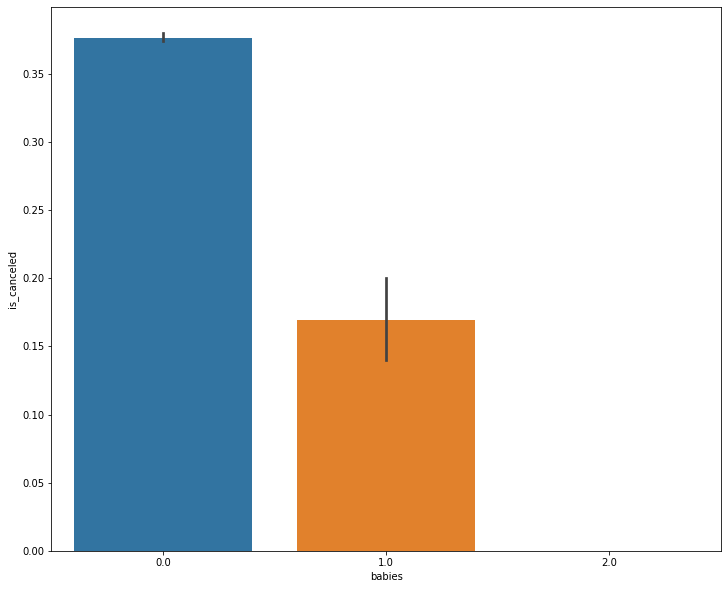

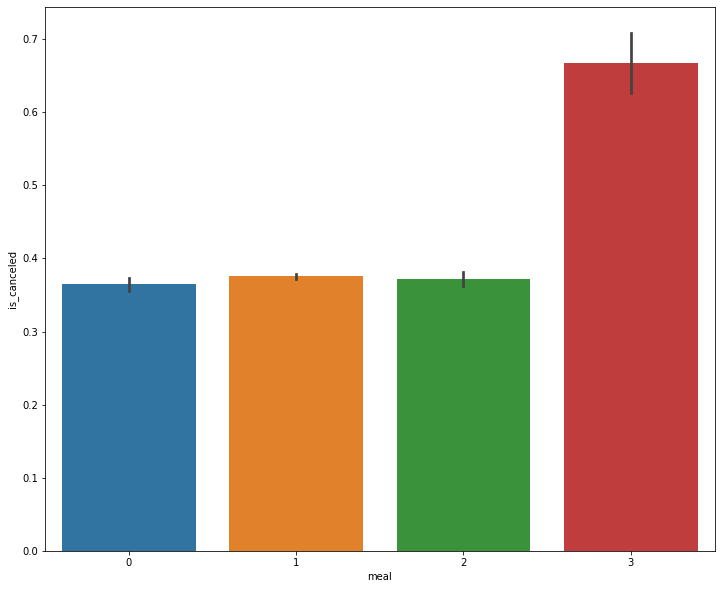

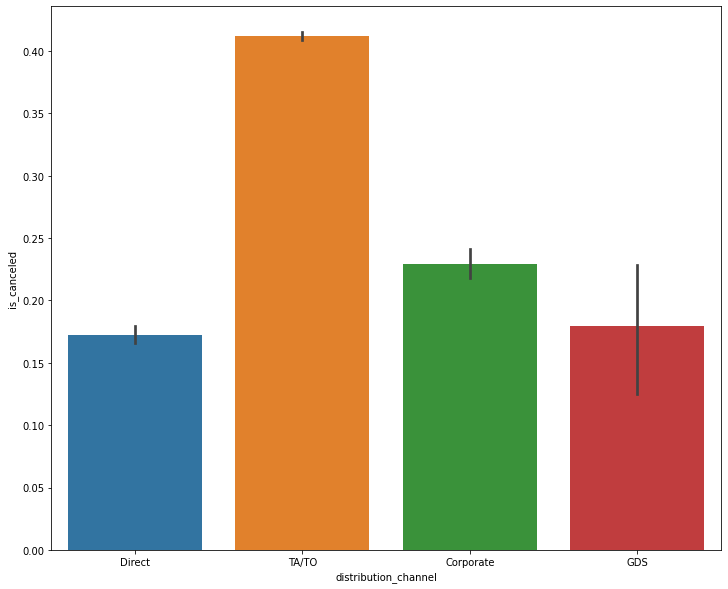

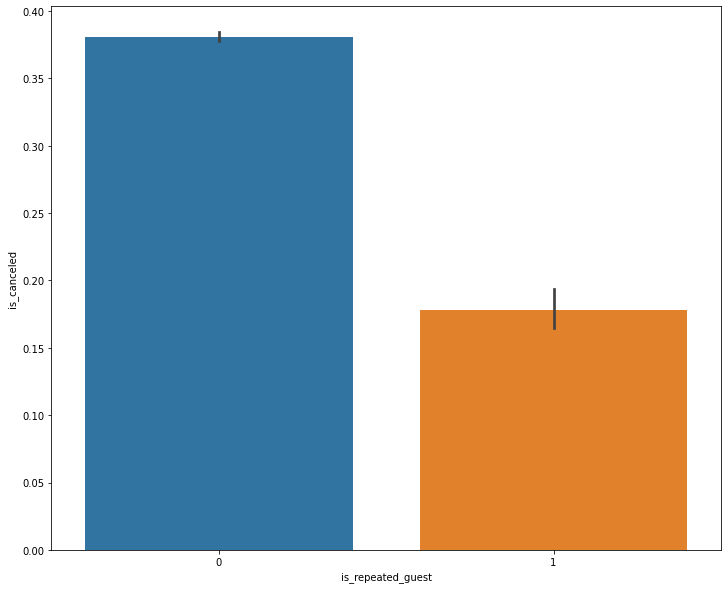

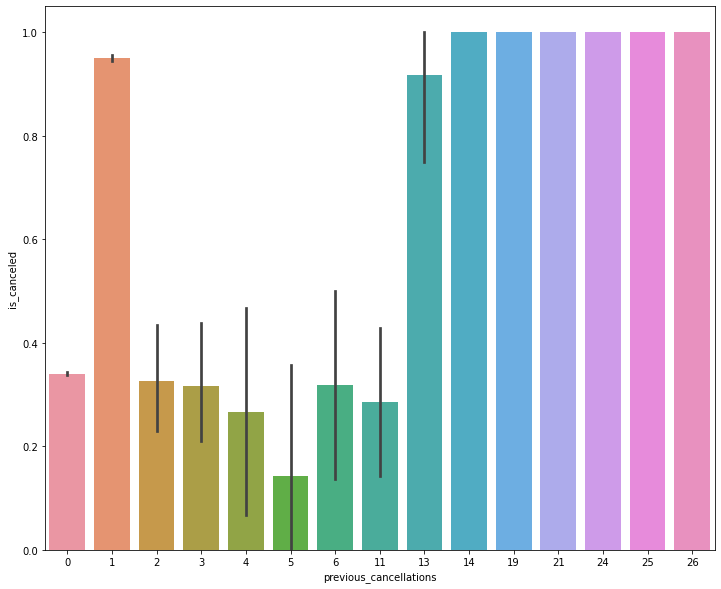

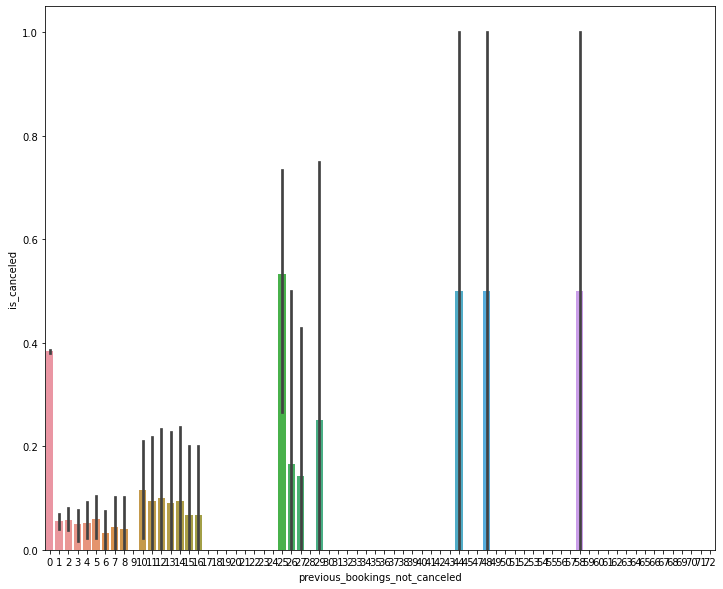

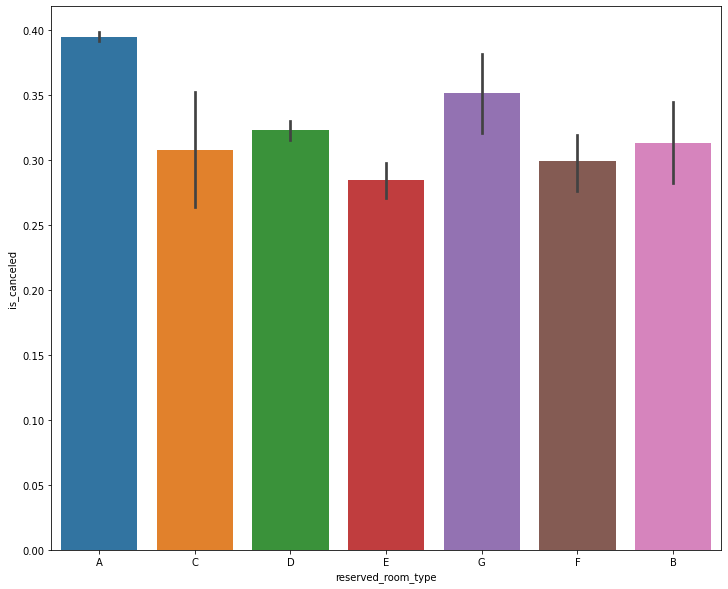

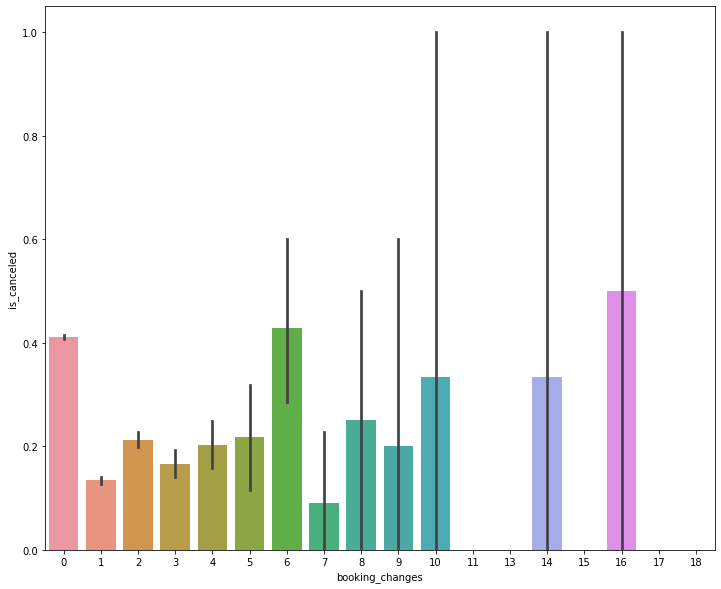

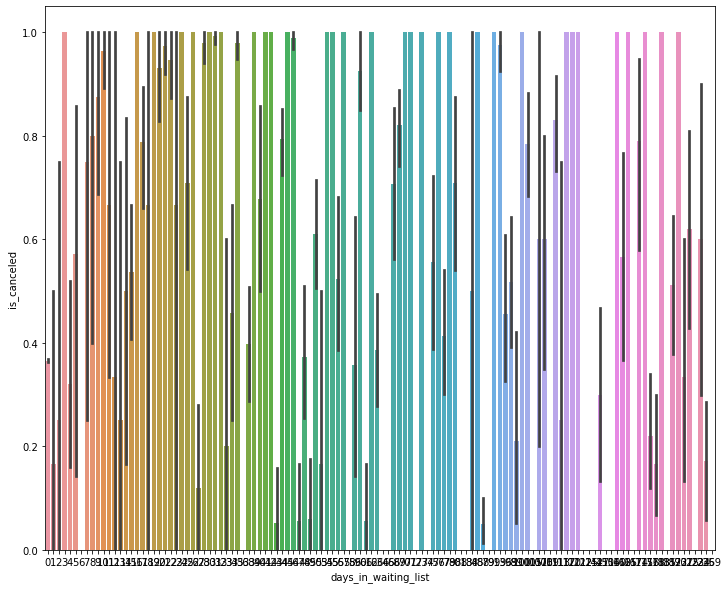

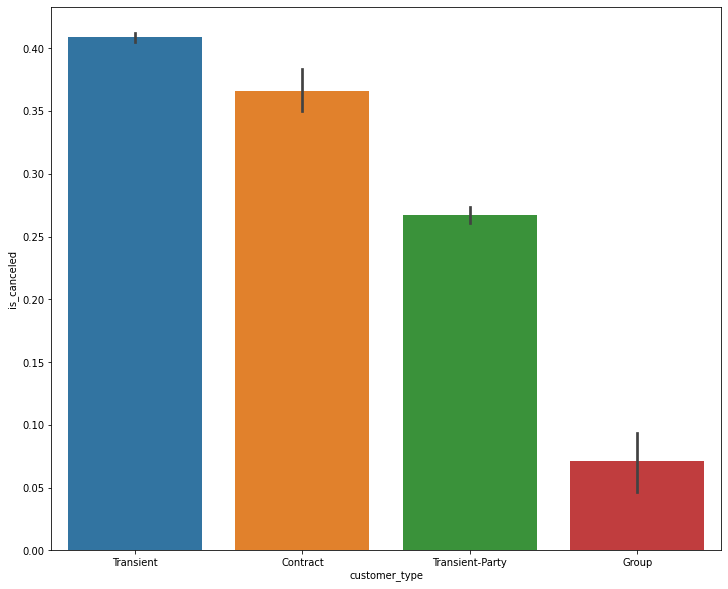

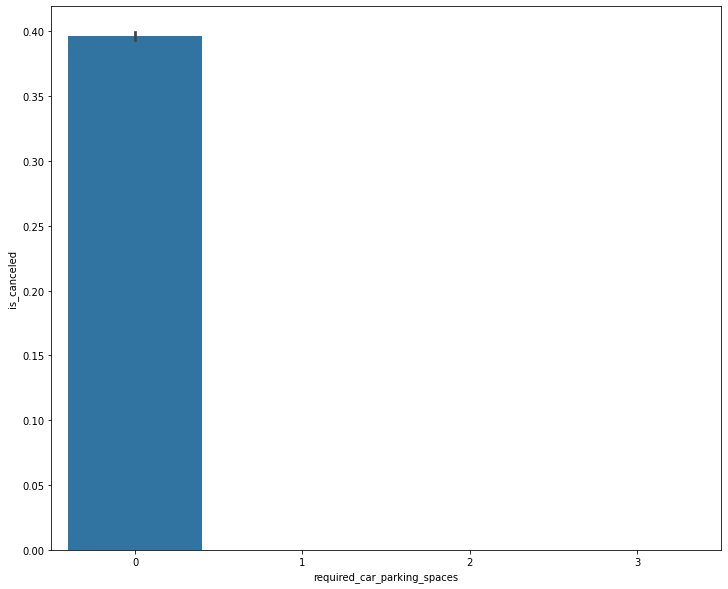

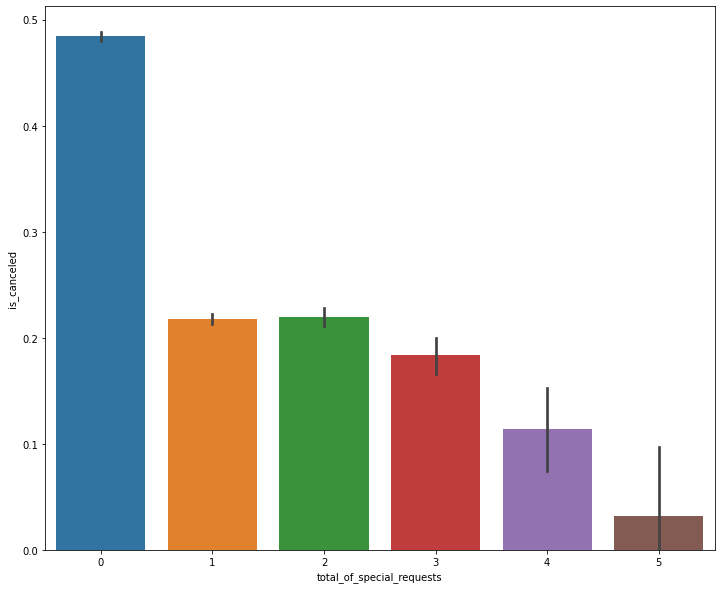

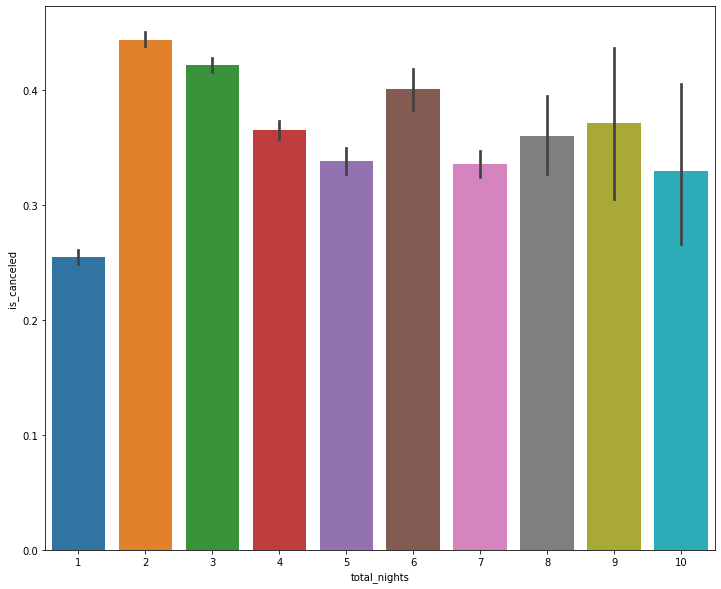

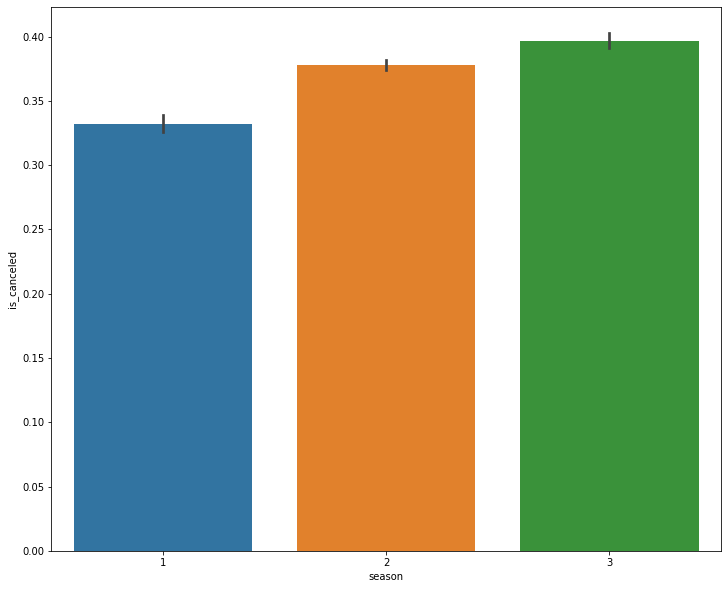

In [31]:
for i in df_train.columns:
    if i !='lead_time' and i !='country' and i != 'is_canceled':
        plt.figure(figsize = (12,10))
        sns.barplot(data= df, y = 'is_canceled', x = i)
        plt.show()

Можно сделать вывод: чем меньше количество специальных отметок в заказе, тем выше вероятность его отмены

total_of_special_requests
0    0.484110
1    0.217401
2    0.219773
3    0.183938
4    0.113537
5    0.032258
Name: is_canceled, dtype: float64


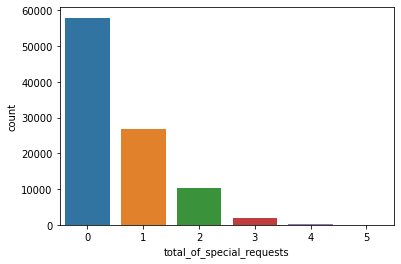

In [32]:
print(df.groupby(by = 'total_of_special_requests')['is_canceled'].mean())
sns.countplot(data= df, x = 'total_of_special_requests')
plt.show()

Самые популярные страны и страны , граждане которых чаще всего отменяют бронь, не пересекаются, следовательно , выводов об этом признаке сделать нельзя

In [33]:
df.groupby(by = 'country')['is_canceled'].mean().sort_values(ascending = False)[:15]

country
HND    1.0000
KHM    1.0000
FJI    1.0000
GGY    1.0000
GLP    1.0000
BEN    1.0000
UMI    1.0000
IMN    1.0000
JEY    1.0000
VGB    1.0000
ZMB    1.0000
MYT    1.0000
AND    1.0000
NIC    1.0000
MAC    0.9375
Name: is_canceled, dtype: float64

In [34]:
df.groupby(by = 'country')['country'].count().sort_values(ascending = False)[:15]

country
PRT    38671
FRA     9426
GBR     9019
ESP     6817
DEU     6253
ITA     3471
IRL     2501
BEL     2111
BRA     1959
NLD     1866
USA     1774
CHE     1465
AUT     1150
CN       957
CHN      920
Name: country, dtype: int64

При увелечении lead_time увеличивается доля отказов от бронирование, но большинство людей не бронируют заказ больше чем за 30 дней, следовательно, из-за недостаточного объема данных однозначного вывода сделать нельзя

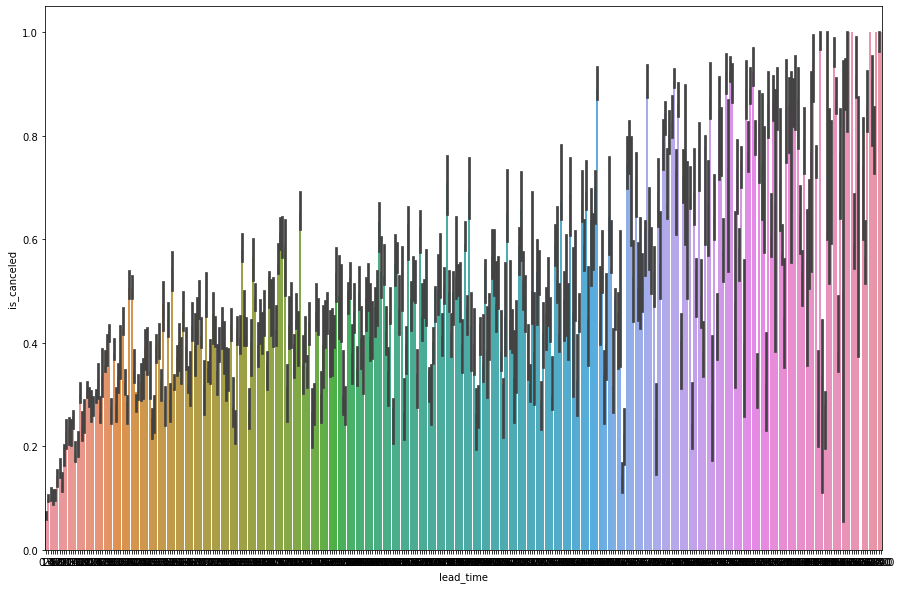

In [35]:
plt.figure(figsize = (15,10))
sns.barplot(data= df, y = 'is_canceled', x = 'lead_time', n_boot = 10)
plt.show()


Чем больше ранее отмененных заказов, тем выше вероятность новой отмены, но у 90% клиентов 0 отмененных заказов, поэтому однозначных выводов сделать нельзя

previous_cancellations
0     0.340026
1     0.950633
2     0.325301
3     0.315789
4     0.266667
5     0.142857
6     0.318182
11    0.285714
13    0.916667
14    1.000000
19    1.000000
21    1.000000
24    1.000000
25    1.000000
26    1.000000
Name: is_canceled, dtype: float64


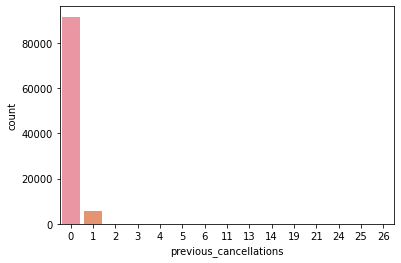

In [36]:
print(df.groupby(by = 'previous_cancellations')['is_canceled'].mean())
sns.countplot(data= df, x = 'previous_cancellations')
plt.show()

90% клиентов отдыхают без младенцев, следовательно выводов о более частой отмену заказов клиентов без детей сделать нельзя (слишком мало данных о клиентах с младенцами)

babies
0.0    0.376648
1.0    0.169106
2.0    0.000000
Name: is_canceled, dtype: float64


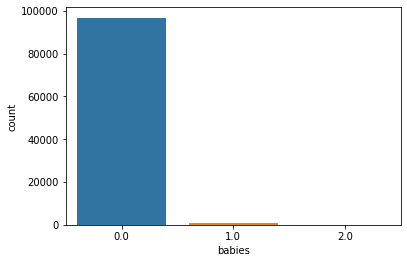

In [37]:
print(df.groupby(by = 'babies')['is_canceled'].mean())
sns.countplot(data= df, x = 'babies')
plt.show()

Параметр distribution_channel чаще всего равено TA/TO, при таком значение показателя вероятность отмены брони в два раза выше остальных

In [38]:
df.groupby(by = 'distribution_channel')['is_canceled'].mean()

distribution_channel
Corporate    0.228967
Direct       0.172480
GDS          0.179348
TA/TO        0.411604
Name: is_canceled, dtype: float64

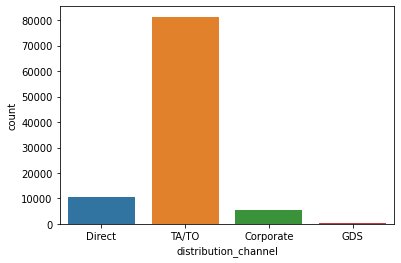

In [39]:
sns.countplot(data= df, x = 'distribution_channel')
plt.show()

Чем больше раннее отмененных бронирования у клиента, тем выше вероятность отмены и в этот раз

In [40]:
df.groupby(by = 'previous_cancellations')['is_canceled'].mean()

previous_cancellations
0     0.340026
1     0.950633
2     0.325301
3     0.315789
4     0.266667
5     0.142857
6     0.318182
11    0.285714
13    0.916667
14    1.000000
19    1.000000
21    1.000000
24    1.000000
25    1.000000
26    1.000000
Name: is_canceled, dtype: float64

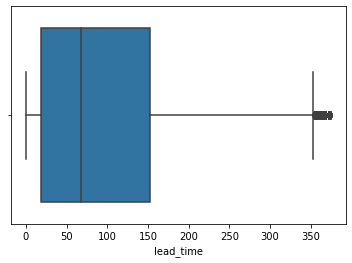

In [41]:
sns.boxplot(data = df, x = 'lead_time')
plt.show()

Разделим датафреймы на признаки и целевой признак.

In [42]:
features_train = df_train.drop('is_canceled',axis = 1)

target_train = df_train['is_canceled']

In [43]:
features_test = df_test.drop('is_canceled',axis = 1)
target_test = df_test['is_canceled']

Проведем onehotcode-ирование категориальных признаков обоих наборов данных

In [44]:
features_categirical = ['country','distribution_channel','reserved_room_type','customer_type',]
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohe.fit(features_train[features_categirical])
def features_ohe(ohe_variable, df_features, features_categ):
    df_features_ohe = pd.DataFrame(
        data=ohe_variable.transform(df_features[features_categ]), 
        columns=ohe_variable.get_feature_names()
    )

    df_features = df_features.drop(features_categ, axis=1)
    df_features = df_features.join(df_features_ohe)
    return df_features    



In [45]:
features_train_enc = features_ohe(ohe, features_train, features_categirical);

In [46]:
features_test_enc = features_ohe(ohe, features_test, features_categirical);

In [47]:
features_train_enc = features_train_enc.fillna(0)
features_test_enc = features_test_enc.fillna(0)


Проведем порядковое кодирование категориальных признаков обоих датафреймов

In [48]:
df_train_tree = df_train
df_test_tree = df_test

In [49]:
def customer_type(df):
    for i in df.index:
        if df['customer_type'][i] == "Contract":
            df['customer_type'][i] = 0
        elif df['customer_type'][i] == "Group":
            df['customer_type'][i] = 1
        elif df['customer_type'][i] == "Transient":
            df['customer_type'][i] = 2
        elif df['customer_type'][i] == "Transient-Party":
            df['customer_type'][i] = 3
    df['customer_type'] = df['customer_type'].astype('int')
    return df
df_train_tree = customer_type(df_train_tree)
df_test_tree = customer_type(df_test_tree)

In [50]:
def room_type(df):
    for i in df.index:
        if df['reserved_room_type'][i] == "G":
            df['reserved_room_type'][i] = 0
        elif df['reserved_room_type'][i] == "F":
            df['reserved_room_type'][i] = 1
        elif df['reserved_room_type'][i] == "E":
            df['reserved_room_type'][i] = 2
        elif df['reserved_room_type'][i] == "D":
            df['reserved_room_type'][i] = 3
        elif df['reserved_room_type'][i] == "C":
            df['reserved_room_type'][i] = 4
        elif df['reserved_room_type'][i] == "B":
            df['reserved_room_type'][i] = 5
        elif df['reserved_room_type'][i] == "A":
            df['reserved_room_type'][i] = 6
    df['reserved_room_type'] = df['reserved_room_type'].astype('int')
    return df

In [51]:
df_train_tree = room_type(df_train_tree)
df_test_tree = room_type(df_test_tree)

In [52]:
def distribution_channel(df):
    for i in df.index:
        if df['distribution_channel'][i] == 'TA/TO':
            df['distribution_channel'][i] = 0
        elif df['distribution_channel'][i] == 'Direct':
            df['distribution_channel'][i] = 1
        elif df['distribution_channel'][i] == 'Corporate':
            df['distribution_channel'][i] = 2
        elif df['distribution_channel'][i] == 'GDS':
            df['distribution_channel'][i] = 3
    df['distribution_channel'] = df['distribution_channel'].astype('int')
    return df
df_train_tree = distribution_channel(df_train_tree)
df_test_tree = distribution_channel(df_test_tree)

In [53]:
for i in df_train_tree['country'].unique():
    a = df_train_tree[df_train_tree['country'] == i]['country'].index
    b = df_test_tree[df_test_tree['country'] == i]['country'].index
    s = random.randint(0,155)
    df_train_tree['country'][a] = s
    df_test_tree['country'][b] = s

In [54]:
a = ['FJI','MDG','CAF','NPL','BHS','UMI','MYT','GTM','GHA','ASM','TGO','MRT','NCL','KIR', 'SDN', 'ATF','SLE','LAO', 'FRO']
for i in a:
    b = df_test_tree[df_test_tree['country'] == i]['country'].index
    s = random.randint(156,200)
    df_test_tree['country'][b] = s

In [55]:
df_test_tree['country'] = df_test_tree['country'].astype('int')
df_train_tree['country'] = df_train_tree['country'].astype('int')

In [56]:
features_train_tree = df_train_tree.drop('is_canceled',axis = 1)

target_train_tree = df_train_tree['is_canceled']
features_test_tree = df_test_tree.drop('is_canceled',axis = 1)
target_test_tree = df_test_tree['is_canceled']

Вывод о проделанной на данном шаге работе:
- Проведена предобработка данных
- Проведен исследовательский анализ данных
- Некоторые категориальные признаки переведены в числовые, при помощи соответсвующих функций
- Проведено onehotcode-ирование категориальных признаков
- Проведено порядковое кодирование категориальных признаков

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Функция profit считаем прибыль. С ее помощью  посчитали прибыль в тестовом датафрейме

In [57]:
def profit(df_test):
    dfsp = pd.DataFrame(df_test[(df_test['is_canceled'] == 0) & (df_test['season'] == 3)].groupby(by = 'reserved_room_type')['total_nights'].sum())
    dfop = pd.DataFrame(df_test[(df_test['is_canceled'] == 0) & (df_test['season'] == 2)].groupby(by = 'reserved_room_type')['total_nights'].sum())
    dfwp = pd.DataFrame(df_test[(df_test['is_canceled'] == 0) & (df_test['season'] == 1)].groupby(by = 'reserved_room_type')['total_nights'].sum())

    dfsy = pd.DataFrame(df_test[(df_test['is_canceled'] == 1) & (df_test['season'] == 3)].groupby(by = 'reserved_room_type')['total_nights'].count())
    dfoy = pd.DataFrame(df_test[(df_test['is_canceled'] == 1) & (df_test['season'] == 2)].groupby(by = 'reserved_room_type')['total_nights'].count())
    dfwy = pd.DataFrame(df_test[(df_test['is_canceled'] == 1) & (df_test['season'] == 1)].groupby(by = 'reserved_room_type')['total_nights'].count())

    s = 0

    s += dfsp.values[0]*1000*1.4-(1+dfsp.values[0]/2)*400
    s += dfsp.values[1]*800*1.4-(1+dfsp.values[1]/2)*350
    s += dfsp.values[2]*600*1.4-(1+dfsp.values[2]/2)*350
    s += dfsp.values[3]*550*1.4-(1+dfsp.values[3]/2)*150
    s += dfsp.values[4]*500*1.4-(1+dfsp.values[4]/2)*150
    s += dfsp.values[5]*450*1.4-(1+dfsp.values[5]/2)*150
    s += dfsp.values[6]*350*1.4-(1+dfsp.values[6]/2)*150
    
    s += dfop.values[0]*1000*1.2-(1+dfop.values[0]/2)*400
    s += dfop.values[1]*800*1.2-(1+dfop.values[1]/2)*350
    s += dfop.values[2]*600*1.2-(1+dfop.values[2]/2)*350
    s += dfop.values[3]*550*1.2-(1+dfop.values[3]/2)*150
    s += dfop.values[4]*500*1.2-(1+dfop.values[4]/2)*150
    s += dfop.values[5]*450*1.2-(1+dfop.values[5]/2)*150
    s += dfop.values[6]*350*1.2-(1+dfop.values[6]/2)*150
    
    s += dfwp.values[0]*1000-(1+dfwp.values[0]/2)*400
    s += dfwp.values[1]*800-(1+dfwp.values[1]/2)*350
    s += dfwp.values[2]*600-(1+dfwp.values[2]/2)*350
    s += dfwp.values[3]*550-(1+dfwp.values[3]/2)*150
    s += dfwp.values[4]*500*1-(1+dfwp.values[4]/2)*150
    s += dfwp.values[5]*450*1-(1+dfwp.values[5]/2)*150
    s += dfwp.values[6]*350*1-(1+dfwp.values[6]/2)*150
    
    s += -(dfsy.values[0]*1000*1.4+(dfsy.values[0])*400)
    s += -(dfsy.values[1]*800*1.4+(dfsy.values[1])*350)
    s += -(dfsy.values[2]*600*1.4+(dfsy.values[2])*350)
    s += -(dfsy.values[3]*550*1.4+(dfsy.values[3])*150)
    s += -(dfsy.values[4]*500*1.4+(dfsy.values[4])*150)
    s += -(dfsy.values[5]*450*1.4+(dfsy.values[5])*150)
    s += -(dfsy.values[6]*350*1.4+(dfsy.values[6])*150)

    s += -(dfoy.values[0]*1000*1.2+(dfoy.values[0])*400)
    s += -(dfoy.values[1]*800*1.2+(dfoy.values[1])*350)
    s += -(dfoy.values[2]*600*1.2+(dfoy.values[2])*350)
    s += -(dfoy.values[3]*550*1.2+(dfoy.values[3])*150)
    s += -(dfoy.values[4]*500*1.2+(dfoy.values[4])*150)
    s += -(dfoy.values[5]*450*1.2+(dfoy.values[5])*150)
    s += -(dfoy.values[6]*350*1.2+(dfoy.values[6])*150)
    
    s += -(dfwy.values[0]*1000*1+(dfwy.values[0])*400)
    s += -(dfwy.values[1]*800*1+(dfwy.values[1])*350)
    s += -(dfwy.values[2]*600*1+(dfwy.values[2])*350)
    s += -(dfwy.values[3]*550*1+(dfwy.values[3])*150)
    s += -(dfwy.values[4]*500*1+(dfwy.values[4])*150)
    s += -(dfwy.values[5]*450*1+(dfwy.values[5])*150)
    s += -(dfwy.values[6]*350*1+(dfwy.values[6])*150)
    return s
profit = int(profit(df_test))
print('Средняя прибыль отеля за год, без внедрения депозитов = ', round(profit/(10**6),2), 'млн.руб')



Средняя прибыль отеля за год, без внедрения депозитов =  19.11 млн.руб


Следовательно, чтобы окупить затраты на разработку прогнозируемая прибыль отеля должна составить 19.6 млн.рублей.

Итог проделанной на данном шаге работе:
1) посчитана прибыль отеля за 2017 год
2) оценена прибыль, необходимая для безубыточного ввода системы депозитов

### Шаг 4. Разработка модели ML

Для оценки качества моделей выберем меру точности (precision). Наша цель сделать так, чтобы машина верно предсказывала случаи, когда в действительности клиента отменил бронирование, следовательно, нужно минимизировать кол-во ложноотрицательных ответов. А Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, то есть, она подходит для наших задач.

Построим модель логистической регрессии , проведем на ней кросс-валидацию.Средня оценка качества модели составила 0.731

In [58]:
s = 0 
a = ['l2', 'None']
si = 0
sj = 0 
warnings.filterwarnings('ignore')
for j in a:
    for i in range (1, 50,10):
        model = LogisticRegression(penalty = j, random_state=12345, max_iter = i, solver = 'sag')
        scores = cross_val_score(model, features_train_enc, target_train, cv =5, scoring = 'precision')
        final_score = sum(scores)/len(scores)
        if final_score>s:
            s = final_score
            si = i
            sj = j
            
print('Средняя оценка качества модели:', s)
print(si)
print(sj)
    

Средняя оценка качества модели: 0.6185519941021163
1
l2


Построим модель дерева решений , проведем на ней кросс-валидацию.Средня оценка качества модели составила 0.56

In [59]:
warnings.filterwarnings('ignore')
si = 0
s = 0
sj = 0
a = ['auto', 'sqrt', 'log2', 'None']
for i in range (1,71,10):
    for j in a:
        model1 = DecisionTreeClassifier(random_state=12345, max_depth = i, max_features = j)
        scores1 = cross_val_score(model1, features_train_tree, target_train_tree, cv =5, scoring = 'precision')
        final_score1 = sum(scores1)/len(scores1)
        if final_score1>s:
            s = final_score1
            si = i
            sj = j
print(s,si, sj)

0.5346395192584191 11 auto


Построим модель случайного , проведем на ней кросс-валидацию.Средня оценка качества модели составила 0.51

In [60]:
warnings.filterwarnings('ignore')
s = 0
si =0
sj = 0
for i in range(35,46, 5):
    for j in range (20,31,5):
        model2 = RandomForestClassifier(random_state = 12345, n_estimators = i, max_depth = j)
        scores2 = cross_val_score(model2, features_train_tree, target_train_tree, cv =5,scoring = 'precision')
        final_score2 = sum(scores2)/len(scores2)
        if final_score2 > s:
            s = final_score2
            si = i 
            sj = j
print(s,si,sj)
                               

0.5171483663969866 45 25


Вывод: наилучшая модель для этой задачи - логистическая регрессия, обучим ее тренировочным набором. Метрика на тренировочном наборе precision = 0.62

In [61]:
features_train_enc.shape

(65061, 189)

In [62]:
model = LogisticRegression(penalty = 'l2',random_state=12345, max_iter = 31, solver = 'sag').fit(features_train_enc,target_train)
predict = model.predict(features_test_enc)
print(precision_score(target_test,predict))

0.7899505766062603


Посчитаем прибыль, которую принесет эта модель , следующим образом: оставим в тестовом наборе данных только те заказы, отмену которых предсказала наша модель правильно, после чего посмотри, какую сумму , могло бы сэкономить введение системы депозитов.

In [63]:
predict = pd.Series(predict)
df1 = df_test

In [64]:
target_test = pd.DataFrame(target_test)

In [65]:
target_test = target_test['is_canceled']

In [66]:
target_test[1]

1

In [67]:
df1 = df_test
df1.index = predict.index

In [68]:
target_test.index = predict.index

In [69]:
s = 0 
a = []
for i in df1.index:
    if(predict[i] == 1)and(target_test[i]==1):
        s = s
    else:
        df1 = df1.drop(index = i)

In [70]:
dfsy = pd.DataFrame(df1[(df1['season'] == 3)].groupby(by = 'reserved_room_type')['total_nights'].count())
dfoy = pd.DataFrame(df1[(df1['season'] == 2)].groupby(by = 'reserved_room_type')['total_nights'].count())
dfwy = pd.DataFrame(df1[(df1['season'] == 1)].groupby(by = 'reserved_room_type')['total_nights'].count())


In [71]:
s = 0
s += (dfsy.values[0]*1000*1.4+(dfsy.values[0])*400)
s += (dfsy.values[1]*800*1.4+(dfsy.values[1])*350)
s += (dfsy.values[2]*600*1.4+(dfsy.values[2])*350)
s += (dfsy.values[3]*550*1.4+(dfsy.values[3])*150)
s += (dfsy.values[4]*500*1.4+(dfsy.values[4])*150)
s += (dfsy.values[5]*450*1.4+(dfsy.values[5])*150)
s += (dfsy.values[6]*350*1.4+(dfsy.values[6])*150)

s += (dfoy.values[0]*1000*1.2+(dfoy.values[0])*400)
s += (dfoy.values[1]*800*1.2+(dfoy.values[1])*350)
s += (dfoy.values[2]*600*1.2+(dfoy.values[2])*350)
s += (dfoy.values[3]*550*1.2+(dfoy.values[3])*150)
s += (dfoy.values[4]*500*1.2+(dfoy.values[4])*150)
s += (dfoy.values[5]*450*1.2+(dfoy.values[5])*150)
s += (dfoy.values[6]*350*1.2+(dfoy.values[6])*150)

s += (dfwy.values[0]*1000*1+(dfwy.values[0])*400)
s += (dfwy.values[1]*800*1+(dfwy.values[1])*350)
s += (dfwy.values[2]*600*1+(dfwy.values[2])*350)
s += (dfwy.values[3]*550*1+(dfwy.values[3])*150)
s += (dfwy.values[4]*500*1+(dfwy.values[4])*150)
s += (dfwy.values[5]*350*1+(dfwy.values[5])*150)

In [72]:
s = int(s*0.8)
print('Прибыль увеличится на = ', round(s/(10**6),2), 'млн. рублей')

Прибыль увеличится на =  2.96 млн. рублей


Итоги работы проделанной на данном этапе :
- При помощи кросс-валидации найдена лучшая модель машинного обучения и ее гиперпараметры
- Оценена прибыль, которую принесет внедрение системы депозитов

### Шаг 5. Опишите портрет «ненадёжного» клиента

Feature: 0, Score: 0.00667
Feature: 1, Score: -0.21533
Feature: 2, Score: 0.04696
Feature: 3, Score: -0.01056
Feature: 4, Score: 0.01623
Feature: 5, Score: -0.02018
Feature: 6, Score: -0.00485
Feature: 7, Score: 0.14159
Feature: 8, Score: 0.00009
Feature: 9, Score: -0.26716
Feature: 10, Score: -0.08689
Feature: 11, Score: 0.98370
Feature: 12, Score: -0.32729
Feature: 13, Score: -0.60917
Feature: 14, Score: -0.00344
Feature: 15, Score: -0.61803
Feature: 16, Score: -0.76417
Feature: 17, Score: -0.00395
Feature: 18, Score: -0.19374
Feature: 19, Score: -0.00021
Feature: 20, Score: 0.01167
Feature: 21, Score: -0.00043
Feature: 22, Score: -0.00035
Feature: 23, Score: 0.01078
Feature: 24, Score: -0.00546
Feature: 25, Score: 0.00017
Feature: 26, Score: -0.00022
Feature: 27, Score: -0.00741
Feature: 28, Score: -0.02906
Feature: 29, Score: -0.00014
Feature: 30, Score: -0.00023
Feature: 31, Score: -0.07264
Feature: 32, Score: 0.00067
Feature: 33, Score: -0.00002
Feature: 34, Score: 0.00238
Featur

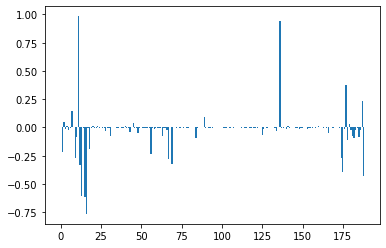

11     0.983703
136    0.941866
177    0.374059
187    0.236834
7      0.141592
         ...   
175   -0.392731
188   -0.425014
13    -0.609171
15    -0.618026
16    -0.764170
Length: 189, dtype: float64

In [73]:
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
importance = pd.Series(importance)
importance.sort_values(ascending  = False)

In [74]:
print(features_train_enc.columns[11])
features_train_enc.columns[16]


previous_cancellations


'total_of_special_requests'

Модель посчитала признака previous_cancellations и distribution_channel самыми важными для анализа. Результаты исследовательского анализа подтверждают это, но из этого списка следует удалить previous_cancellations , ввиду слишком малого кол-ва данных для анализа, а добавить в этот список следует total_of_special_requests - чем меньше специальных поправок, тем выше вероятность отмены


Итог проделанной на данном шаге работы:
составлен портрет 'ненадежного' клиента:
- total_of_special_requests - чем меньше специальных поправок, тем выше вероятность отмены
- distribution_channel == TA/TO


### Шаг 6. Напишите общий вывод

Общий вывод:
1) обучена модель линейной регрессии :
- метрика precision = 0.79
- Сделан вывод о целесообразности внедрения системы депозитов: прогнозируется увелечение прибыль на 3 млн. рублей

2) составлен портрет 'ненадежного' клиента:
- distribution_channel == TA/TO
- total_of_special_requests - чем меньше специальных поправок, тем выше вероятность отмены